# Cleaning up 311 Service Request Data

In this jupyter notebook we will explore the datasets used for our project. We will primarily focus on


In [15]:
![ -f ../requirements.txt ] && pip install -r ../requirements.txt -q || pip install -r ./requirements.txt -q

In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from census import Census
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("../")
print("Current working directory:", os.getcwd())

# Loading environment variables
from dotenv import load_dotenv

load_dotenv()
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY")

Current working directory: /home/manpazito/projects/class-materials/CY PLAN 101/311-neighborhood-equity


## 311 Cases in 2023

Below is the raw table of all 311 service requests opened in 2023.


In [17]:
serv_req_df = pd.read_csv("data/raw/311_Cases_2023.csv")

Let's do a quick analysis of what this dataset consists of.


In [18]:
serv_req_df.sample(5)

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,...,Police District,Latitude,Longitude,Point,point_geom,Source,Media URL,BOS_2012,data_as_of,data_loaded_at
126194,16422374,02/13/2023 08:06:00 AM,02/15/2023 07:06:00 AM,02/15/2023 07:06:00 AM,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,Hazardous Materials,Liquids - Oil/Paint/Other,...,MISSION,37.761968,-122.416039,"(37.76196786, -122.41603855)",POINT (-122.416038551 37.761967862),Mobile/Open311,https://mobile311.sfgov.org/media/san_francisc...,9.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
709543,17433587,10/17/2023 10:23:00 AM,11/03/2023 12:05:25 PM,11/03/2023 12:05:25 PM,Closed,Case Resolved - SES Graffiti Crew - Paint - P...,DPW Ops Queue,Illegal Postings,Illegal Postings - Multiple_Postings,Multiple Postings,...,NORTHERN,37.802543,-122.436627,"(37.8025426, -122.4366274)",POINT (-122.4366274 37.8025426),Web,NaN,NaN,2024/04/10 10:23:00 AM,2024/09/11 05:09:50 PM
357273,16737521,05/01/2023 10:05:00 AM,05/02/2023 07:16:00 AM,05/02/2023 07:16:00 AM,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,...,PARK,37.770093,-122.446322,"(37.77009324, -122.44632239)",POINT (-122.446322389 37.770093245),Mobile/Open311,NaN,5.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
653730,16635510,04/05/2023 07:40:00 PM,04/06/2023 06:44:34 AM,04/06/2023 06:44:34 AM,Closed,Removed - Case Resolved,SoMa West CBD Queue,Illegal Postings,Illegal Postings - Posted_on_Traffic_Light,Posted on Traffic Light,...,SOUTHERN,37.772931,-122.412844,"(37.77293055, -122.41284356)",POINT (-122.412843556 37.77293055),Mobile/Open311,https://mobile311.sfgov.org/media/san_francisc...,6.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
586143,16257430,01/04/2023 07:34:00 PM,01/24/2024 12:23:15 PM,01/24/2024 12:23:15 PM,Closed,Case Resolved,DPW Ops Queue,Graffiti,Graffiti on Sidewalk_in_front_of_property,Sidewalk_in_front_of_property - Offensive,...,PARK,37.770728,-122.441903,"(37.77072833, -122.44190333)",POINT (-122.441903333 37.770728333),Mobile/Open311,http://mobile311.sfgov.org/reports/16257430/ph...,NaN,2024/04/10 10:23:00 AM,2024/09/11 05:09:50 PM


In [19]:
print(serv_req_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840206 entries, 0 to 840205
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CaseID                 840206 non-null  int64  
 1   Opened                 840206 non-null  object 
 2   Closed                 808740 non-null  object 
 3   Updated                840206 non-null  object 
 4   Status                 840206 non-null  object 
 5   Status Notes           835836 non-null  object 
 6   Responsible Agency     840206 non-null  object 
 7   Category               840206 non-null  object 
 8   Request Type           840206 non-null  object 
 9   Request Details        831141 non-null  object 
 10  Address                840206 non-null  object 
 11  Street                 830788 non-null  object 
 12  Supervisor District    830788 non-null  float64
 13  Neighborhood           830704 non-null  object 
 14  Analysis Neighborhood  732571 non-nu

## Cleaning the Service Requests DataFrame

### Initial Cleanup


In [20]:
# Selecting useful columns
useful_cols = [
    "CaseID",
    "Opened",
    "Closed",
    "Updated",
    "Status",
    "Status Notes",
    "Responsible Agency",
    "Category",
    "Request Type",
    "Request Details",
    "Neighborhood",
    "Analysis Neighborhood",
    "Police District",
    "Latitude",
    "Longitude",
    "Source",
]

serv_req_df = serv_req_df[useful_cols].copy()

# Removing duplicates and filtering by SF bounding box
serv_req_df.drop_duplicates(subset="CaseID", inplace=True)
serv_req_df = serv_req_df[
    serv_req_df["Latitude"].between(37.6, 37.9)
    & serv_req_df["Longitude"].between(-123.2, -122.3)
]

# Simplifying column names
serv_req_df.columns = serv_req_df.columns.str.strip().str.lower().str.replace(" ", "_")

print("DataFrame snippet so far:\n")
display(serv_req_df.sample(3))

DataFrame snippet so far:



,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,neighborhood,analysis_neighborhood,police_district,latitude,longitude,source
589380,17250153,09/02/2023 09:14:00 PM,09/06/2023 11:20:00 AM,09/06/2023 11:20:00 AM,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Russian Hill,Russian Hill,CENTRAL,37.799560,-122.416035,Mobile/Open311
558254,16627095,04/04/2023 06:47:58 AM,04/04/2023 03:06:12 PM,04/04/2023 03:06:12 PM,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,Portola,Portola,BAYVIEW,37.730170,-122.404807,Mobile/Open311
598106,17400248,10/09/2023 10:57:00 AM,10/09/2023 11:09:36 AM,10/09/2023 11:09:36 AM,Closed,Case is a Duplicate - This issue has already b...,Parking Enforcement Dispatch Queue,Parking Enforcement,Parking_on_Sidewalk,White - Cadillac - 9BDP426,Silver Terrace,Bayview Hunters Point,BAYVIEW,37.734828,-122.392138,Phone


### Categorizing Categoricals

We're just marking a column if they're a categorical or not.


In [21]:
cat_cols = [
    "status",
    "status_notes",
    "responsible_agency",
    "category",
    "request_type",
    "request_details",
    "neighborhood",
    "analysis_neighborhood",
    "police_district",
    "source",
]

for col in cat_cols:
    if col in serv_req_df.columns:
        serv_req_df[col] = (
            serv_req_df[col]
            .astype("string")  # efficient string dtype
            .str.strip()  # remove leading/trailing spaces
            .str.replace(r"\s+", " ", regex=True)  # collapse multiple spaces
            .str.replace("_", " ", regex=False)  # underscores → spaces
            .str.title()  # nice display casing
        )

### Temporal Cleanup


In [22]:
# Properly format date columns
date_cols = ["opened", "closed", "updated"]
for col in date_cols:
    serv_req_df[col] = pd.to_datetime(
        serv_req_df[col], format="%m/%d/%Y %I:%M:%S %p", errors="coerce"
    )

# Deriving new temporal columns
serv_req_df["year"] = serv_req_df["opened"].dt.year.astype("Int16")
serv_req_df["month"] = serv_req_df["opened"].dt.month.astype("Int8")
serv_req_df["dow"] = serv_req_df["opened"].dt.day_name()
serv_req_df["hour"] = serv_req_df["opened"].dt.hour.astype("Int8")
serv_req_df["request_duration_hrs"] = (
    serv_req_df["closed"] - serv_req_df["opened"]
).dt.total_seconds() / 3600

### Spatial Cleanup


In [ ]:
# points (WGS84)
serv_req_gdf = gpd.GeoDataFrame(
    serv_req_df.dropna(subset=["longitude", "latitude"]).copy(),
    geometry=gpd.points_from_xy(serv_req_df.longitude, serv_req_df.latitude),
    crs="EPSG:4326",
)

sf_tracts_gdf = gpd.read_file("data/processed/sf_tracts_cleaned_2023.gpkg")

# match CRS
sf_tracts_gdf = sf_tracts_gdf.to_crs(serv_req_gdf.crs)

# keep ONLY points inside tracts (+ add GEOID)
serv_req_gdf = gpd.sjoin(
    serv_req_gdf,
    sf_tracts_gdf[["GEOID", "geometry"]],
    how="inner",
    predicate="intersects",
).drop(columns=["index_right"])

### Some final touches

Some final touches to make sure each column is the right data type.


In [24]:
serv_req_gdf["neighborhood"] = (
    serv_req_gdf["analysis_neighborhood"]
    .fillna(serv_req_gdf["neighborhood"])
    .str.strip()
    .str.title()
)
serv_req_gdf.drop(columns=["analysis_neighborhood"], inplace=True)

serv_req_gdf["category"] = serv_req_gdf["category"].str.title().str.strip()
serv_req_gdf["responsible_agency"] = (
    serv_req_gdf["responsible_agency"].str.replace("_", " ").str.title()
)

serv_req_gdf["is_closed"] = serv_req_gdf["status"].eq("Closed").astype("bool")

bins = [0, 1, 24, 72, np.inf]
labels = ["<1hr", "1–24hr", "1–3days", ">3days"]
serv_req_gdf["response_time_cat"] = pd.cut(
    serv_req_gdf["request_duration_hrs"], bins=bins, labels=labels
)

# A preview of the cleaned GeoDataFrame
display(serv_req_gdf.sample(3))
print("Updated column data types:\n", serv_req_gdf.dtypes)

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,source,year,month,dow,hour,request_duration_hrs,geometry,GEOID,is_closed,response_time_cat
775298,17157382,2023-08-12 12:54:00,2023-08-22 06:22:00,2023-08-22 06:22:00,Closed,Dpt Abandoned Vehicles- Gone On Arrival - 08/2...,Dpt Abandoned Vehicles Work Queue,Abandoned Vehicle,Abandoned Vehicles,Dpt Abandoned Vehicles Low,...,Web,2023,8,Saturday,12,233.466667,POINT (-122.4911 37.73497),06075033001,True,>3days
809792,17613583,2023-12-01 15:12:00,2023-12-01 16:15:29,2023-12-01 16:15:29,Closed,Case Resolved,Recology Overflowing,Street And Sidewalk Cleaning,City Garbage Can Overflowing,City Garbage Can Overflowing,...,Mobile/Open311,2023,12,Friday,15,1.058056,POINT (-122.46767 37.78178),06075040200,True,1–24hr
106287,16794827,2023-05-15 20:58:35,2023-05-16 00:10:00,2023-05-16 00:10:00,Closed,Comment Noted - Call Sfpd,311 Supervisor Queue,Noise Report,Noise Issue,Other,...,Web,2023,5,Monday,20,3.190278,POINT (-122.41261 37.75241),06075022901,True,1–24hr


Updated column data types:
 caseid                           int64
opened                  datetime64[ns]
closed                  datetime64[ns]
updated                 datetime64[ns]
status                  string[python]
status_notes            string[python]
responsible_agency      string[python]
category                string[python]
request_type            string[python]
request_details         string[python]
neighborhood            string[python]
police_district         string[python]
latitude                       float64
longitude                      float64
source                  string[python]
year                             Int16
month                             Int8
dow                             object
hour                              Int8
request_duration_hrs           float64
geometry                      geometry
GEOID                           object
is_closed                         bool
response_time_cat             category
dtype: object


### Simple Plot


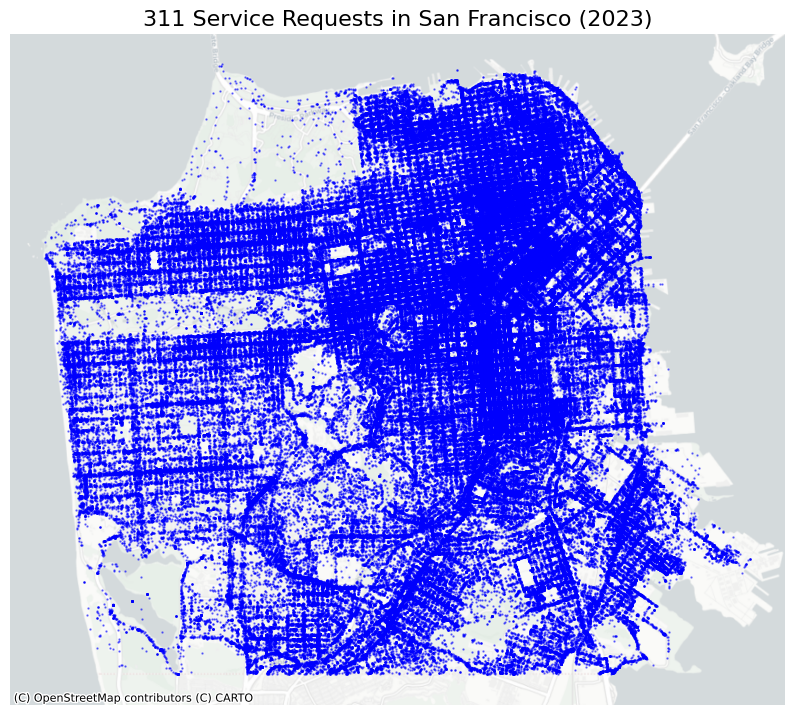

In [25]:
# Plot a simple visualization of the points
fig, ax = plt.subplots(figsize=(10, 10))
serv_req_gdf.plot(ax=ax, markersize=0.5, color="blue", alpha=0.5)
ax.set_title("311 Service Requests in San Francisco (2023)", fontsize=16)
# Overlay a basemap for context (optional)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=serv_req_gdf.crs)
ax.axis("off")
plt.show()

### Quick Dashboard Describing Data


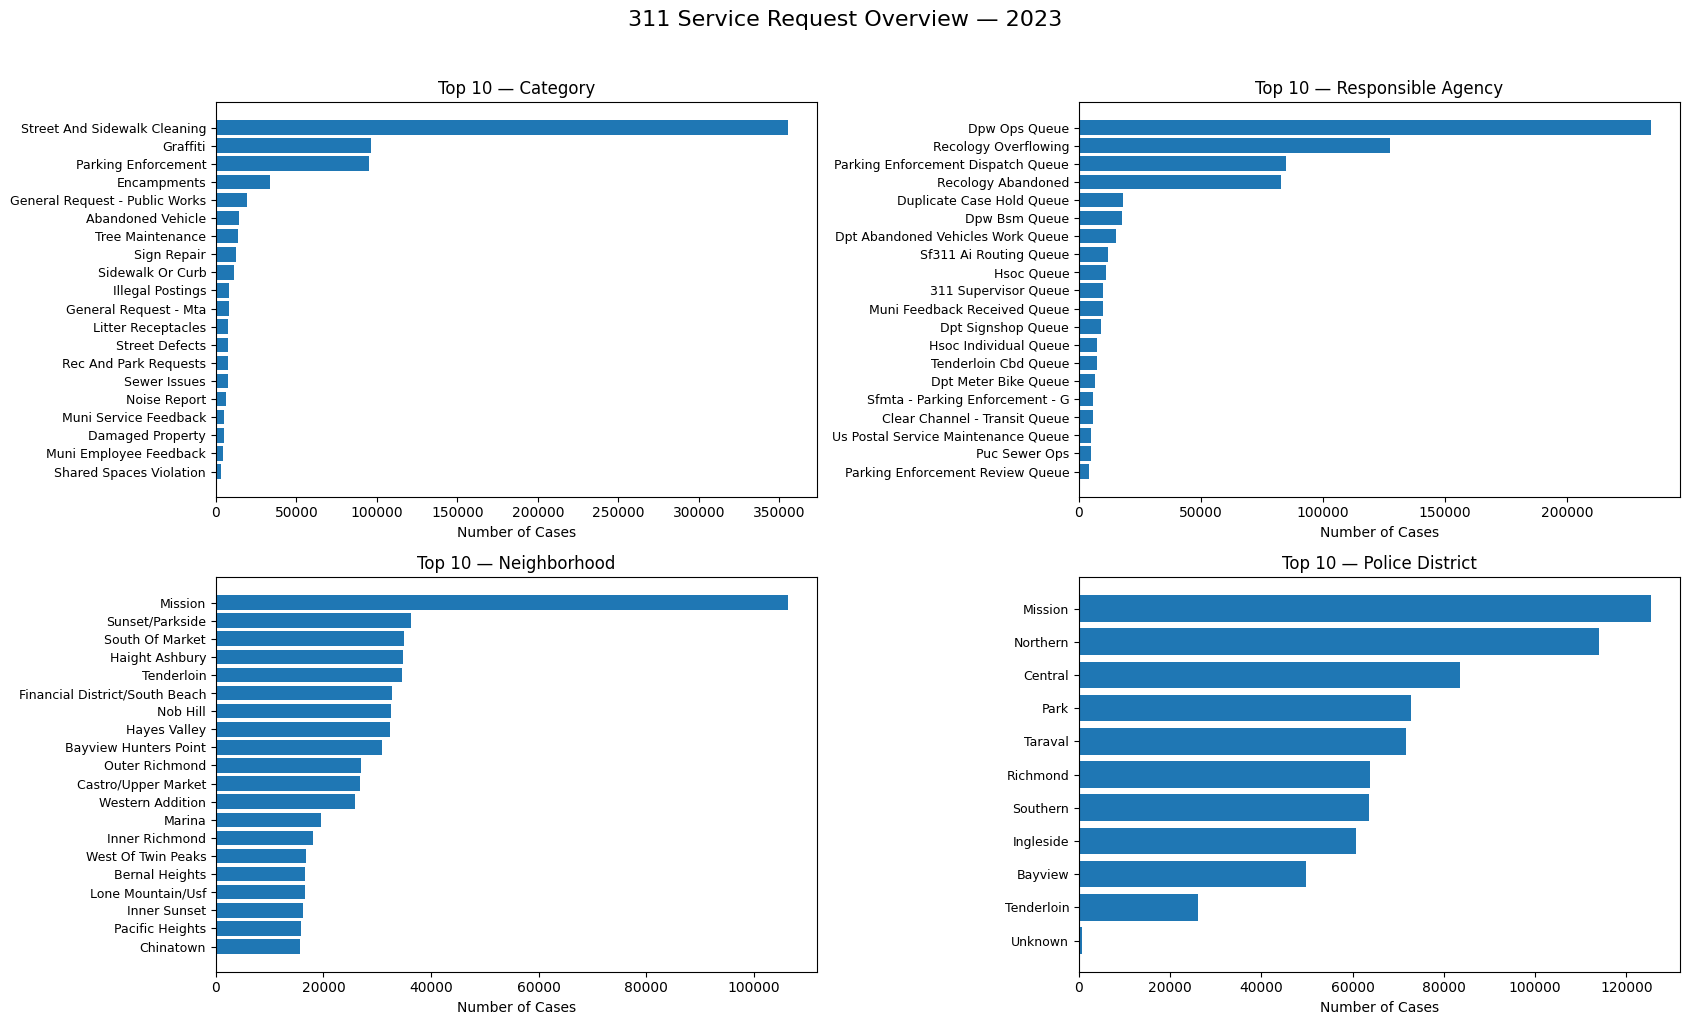

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))
axes = axes.flatten()

cat_info = [
    ("category", "Top 10 — Category"),
    ("responsible_agency", "Top 10 — Responsible Agency"),
    ("neighborhood", "Top 10 — Neighborhood"),
    ("police_district", "Top 10 — Police District"),
]

for ax, (col, title) in zip(axes, cat_info):
    if col in serv_req_gdf.columns:
        vc = (
            serv_req_gdf[col]
            .fillna("Unknown")
            .value_counts()
            .nlargest(20)
            .sort_values()
        )
        ax.barh(vc.index, vc.values)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Number of Cases")
        ax.tick_params(axis="y", labelsize=9)
    else:
        ax.text(0.5, 0.5, f"{col} not found", ha="center", va="center")
        ax.set_axis_off()

plt.suptitle("311 Service Request Overview — 2023", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

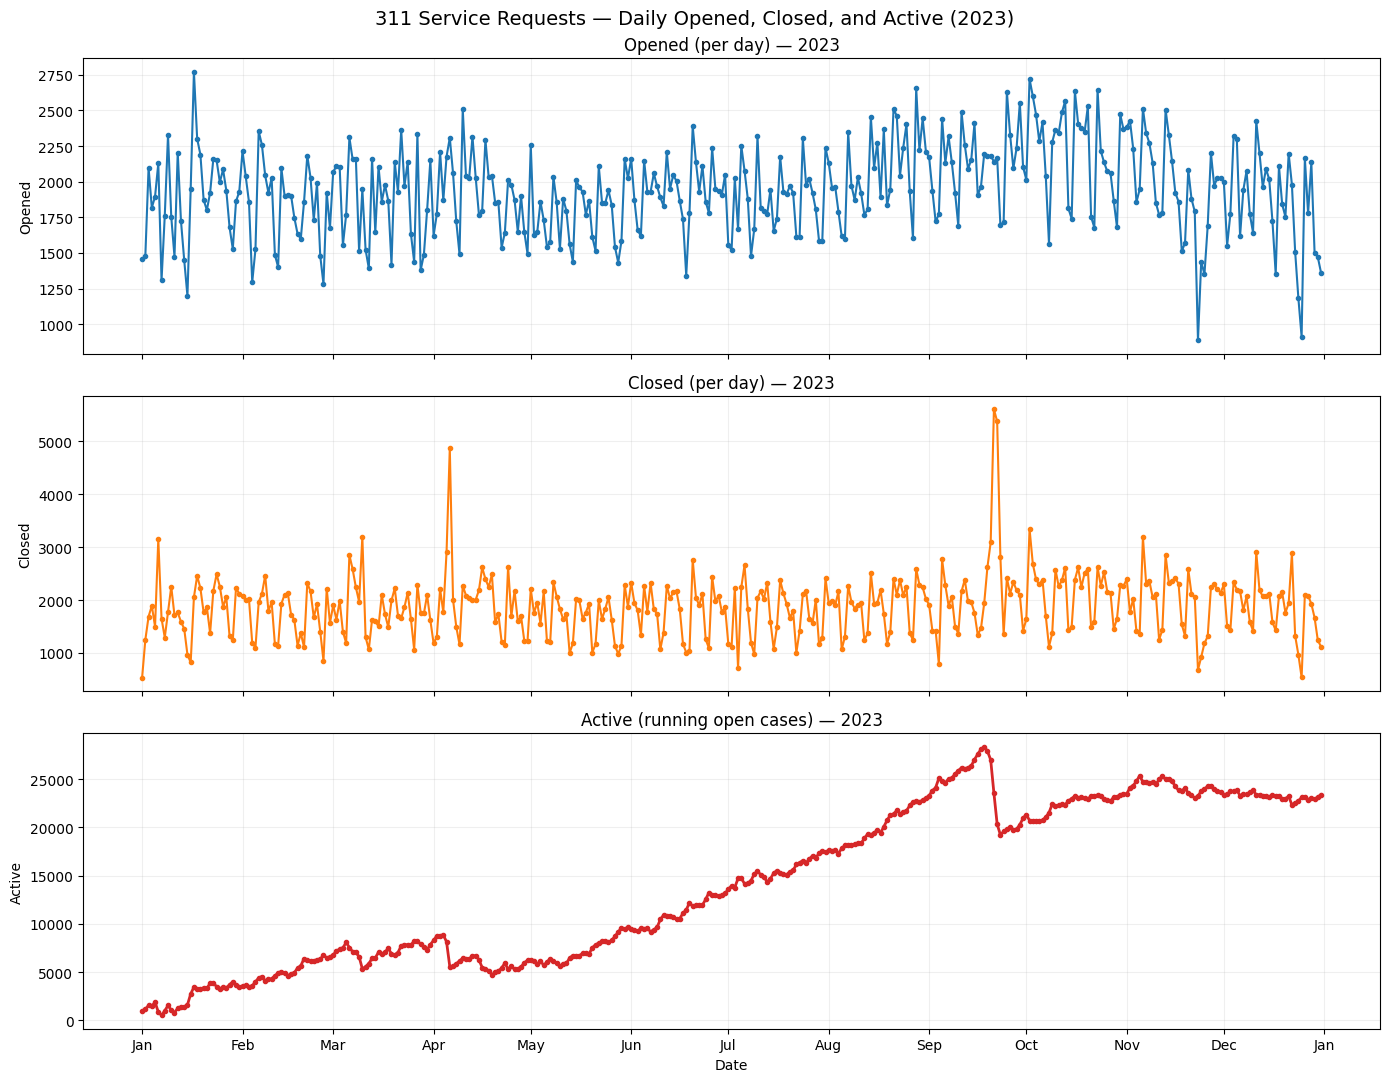

,all_cases,closed_cases,active_end_of_month
month,,,
2015-06-01,1,1,0
2015-07-01,1,1,0
2016-04-01,2,2,0
2016-05-01,3,3,0
2016-06-01,2,2,0
...,...,...,...
2023-11-01,58691,56307,21062
2023-12-01,56648,54572,23138
2024-06-01,3,3,23138


In [27]:
import matplotlib.dates as mdates

# Ensure datetime and filter to 2023
df = serv_req_gdf.copy()
df["opened"] = pd.to_datetime(df["opened"], errors="coerce")
df["closed"] = pd.to_datetime(df["closed"], errors="coerce")

# Keep records with at least one of opened/closed in 2023
df_2023 = df[(df["opened"].dt.year == 2023) | (df["closed"].dt.year == 2023)].copy()

if df_2023.empty:
    print("No records with opened/closed year == 2023 found.")
else:
    # daily opened/closed counts (timestamped at midnight)
    df_2023["open_day"] = df_2023["opened"].dt.floor("D")
    df_2023["close_day"] = df_2023["closed"].dt.floor("D")

    opened_daily = df_2023.groupby("open_day").size().sort_index()
    closed_daily = df_2023.groupby("close_day").size().sort_index()

    # continuous date index for all days of 2023
    all_days = pd.date_range("2023-01-01", "2023-12-31", freq="D")
    opened_daily = opened_daily.reindex(all_days, fill_value=0)
    closed_daily = closed_daily.reindex(all_days, fill_value=0)

    # cumulative sums
    opened_cum = opened_daily.cumsum()
    closed_cum = closed_daily.cumsum()

    # active backlog = cumulative opened - cumulative closed
    active_daily = opened_cum - closed_cum

    # --- Subplots: separate stacked plots for opened, closed, and active ---
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 11), sharex=True)
    ax_open, ax_closed, ax_active = axes

    # Opened (per day)
    ax_open.plot(
        all_days,
        opened_daily,
        color="tab:blue",
        linewidth=1.5,
        marker="o",
        markersize=3,
    )
    ax_open.set_title("Opened (per day) — 2023")
    ax_open.set_ylabel("Opened")
    ax_open.grid(alpha=0.2)

    # Closed (per day)
    ax_closed.plot(
        all_days,
        closed_daily,
        color="tab:orange",
        linewidth=1.5,
        marker="o",
        markersize=3,
    )
    ax_closed.set_title("Closed (per day) — 2023")
    ax_closed.set_ylabel("Closed")
    ax_closed.grid(alpha=0.2)

    # Active (running open cases)
    ax_active.plot(
        all_days, active_daily, color="tab:red", linewidth=2, marker="o", markersize=3
    )
    ax_active.set_title("Active (running open cases) — 2023")
    ax_active.set_ylabel("Active")
    ax_active.set_xlabel("Date")
    ax_active.grid(alpha=0.2)

    # X axis formatting (months)
    ax_active.xaxis.set_major_locator(mdates.MonthLocator())
    ax_active.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

    plt.suptitle(
        "311 Service Requests — Daily Opened, Closed, and Active (2023)",
        fontsize=14,
        y=0.98,
    )
    plt.tight_layout()
    plt.show()

    # --- Monthly summary table (all, closed, active at month-end) ---
    df_2023["month"] = df_2023["opened"].dt.to_period("M").dt.to_timestamp()
    ts_opened_monthly = df_2023.groupby("month").size().sort_index()
    ts_closed_monthly = (
        df_2023[df_2023["is_closed"].fillna(False)]
        .groupby("month")
        .size()
        .reindex(ts_opened_monthly.index, fill_value=0)
    )

    # active at month end = cumulative opened - cumulative closed at each month
    opened_cum_monthly = ts_opened_monthly.cumsum()
    closed_cum_monthly = ts_closed_monthly.cumsum()
    active_monthly = opened_cum_monthly - closed_cum_monthly

    try:
        summary = (
            pd.DataFrame(
                {
                    "all_cases": ts_opened_monthly,
                    "closed_cases": ts_closed_monthly,
                    "active_end_of_month": active_monthly,
                }
            )
            .fillna(0)
            .astype(int)
        )
        display(summary)
    except Exception:
        pass

### Caching DataFrame

This helps having to re-run the notebook the cleaning on each notebook boot.


In [28]:
serv_req_gdf.to_parquet("data/processed/serv_req_cleaned.parquet", index=False)